In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = pd.read_csv('./mnist.csv', header=None)
feature = data.iloc[:,1:]
label = data.iloc[:,0]

In [2]:
from sklearn.preprocessing import StandardScaler

sc_X= StandardScaler()

In [3]:
def apply_pca(X, n_components=10):
    """
    Apply PCA on the given dataset and return the projected data.
    
    Parameters:
    - X: Input data (samples x features)
    - n_components: Number of principal components to retain
    
    Returns:
    - X_pca: Data projected onto the top n_components principal components
    """
    cov_matrix = np.cov(X, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    sorted_indices = np.argsort(eigenvalues)[::-1] # descending order
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    projected_matrix = eigenvectors[:, :n_components]
    # project original feature onto the principal components 
    X_pca = np.dot(X, projected_matrix)
    
    return X_pca


In [4]:
# Calculate Cov
X = feature
X = sc_X.fit_transform(X)

X_pca = apply_pca(X, n_components=10)

In [5]:
# # Test PCA covariance matrix 
# from sklearn.decomposition import PCA

# sk_pca = PCA(n_components=10)
# X_sk_pca = sk_pca.fit_transform(X)
# print(X_sk_pca)


In [6]:
np.savetxt("MINST-PCA.csv",X_pca,delimiter=",")
print("The projected covariance matrix: \n",X_pca)
print("The projected covariance matrix size is: ",X_pca.shape)

The projected covariance matrix: 
 [[  0.92362297   4.72860688  -0.22118776 ...   0.63273492  -0.62410696
   -0.19149663]
 [ -8.66851624   7.08182293  -4.17723207 ...   2.46248647  -0.54625358
    2.67992234]
 [ -2.18464318 -10.6560583   -4.67775635 ...   6.24262776  -1.18002244
   -0.20679461]
 ...
 [  2.00964131  10.08236699  -1.29569678 ...  -2.11152836  -7.53389858
    1.87222262]
 [ -0.96415153   2.95967152   0.35211149 ...   5.43497534  -0.94492879
    1.39771081]
 [  2.09579264  -0.25065414  -8.7736376  ...   1.08008174  -0.52325051
    1.28049432]]
The projected covariance matrix size is:  (6000, 10)


In [7]:
# KMeans implemented by EM algorithm
def e_step(data, centroids):
    data = np.array(data)
    centroids = np.array(centroids)
    
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    clusters = np.argmin(distances, axis=1)
    return clusters

def m_step(data, clusters, k):
    data = np.array(data)
    clusters = np.array(clusters)
    
    new_centroids = np.array([data[clusters == i].mean(axis=0) for i in range(k)])
    return new_centroids

def compute_loss(data, clusters, centroids):
    data = np.array(data)
    clusters = np.array(clusters).ravel()
    centroids = np.array(centroids)
    
    centroids_for_data = centroids[clusters]
    distances = np.linalg.norm(data - centroids_for_data, axis=1)
    loss = np.sum(distances**2)
    return loss

def initialize_kmeans_pp(data, k):
    data = np.array(data)
    
    centroids = []
    first_centroid = data[np.random.choice(data.shape[0])]
    centroids.append(first_centroid)

    for _ in range(k - 1):
        distances = np.min(np.linalg.norm(data[:, np.newaxis] - centroids, axis=2), axis=1)
        probs = distances ** 2
        probs /= probs.sum()
        next_centroid = data[np.random.choice(data.shape[0], p=probs)]
        centroids.append(next_centroid)

    return np.array(centroids)

def kmeans(data, k=10, max_iters=100, tol=1e-4):
    np.random.seed(42)
    data = np.array(data)
    
    centroids = initialize_kmeans_pp(data, k)
    loss_values = []
    
    for _ in range(max_iters):
        clusters = e_step(data, centroids)
        new_centroids = m_step(data, clusters, k)
        
        loss = compute_loss(data, clusters, centroids)
        loss_values.append(loss)
        
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids
    
    return clusters, centroids, loss_values


In [8]:
clusters, centroids, losses = kmeans(X,k=10)

In [9]:
centroids.shape

(10, 784)

In [10]:
# Draw the loss curve of KMeans
def plot_loss_curve(loss_values, step=1):
    plt.plot(loss_values[::step], 'o-', markersize=4)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('K-means Loss Curve')
    plt.show()


In [11]:
len(losses)

35

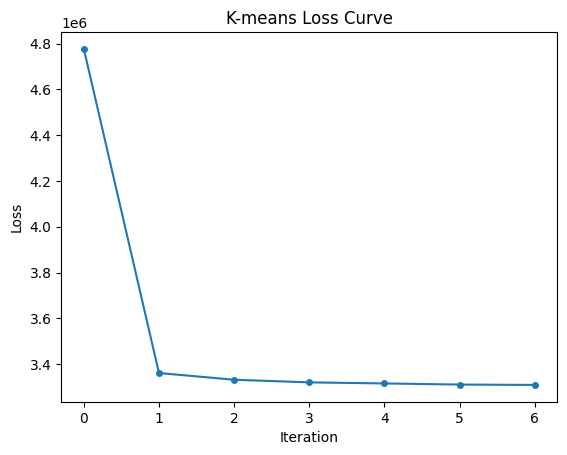

In [12]:
plot_loss_curve(losses, step=5)

In [13]:
# # Test KMeans Loss Curve
# from sklearn.cluster import KMeans

# X_kmeans = feature
# X_kmeans = sc_X.fit_transform(X_kmeans)

# max_iters = 100
# inertia_values = []

# for i in range(1, max_iters + 1):
#     kmeans = KMeans(n_clusters=10, max_iter=i, n_init=1, init='random', random_state=0)
#     kmeans.fit(X)
#     inertia_values.append(kmeans.inertia_)

# plt.figure(figsize=(10, 6))
# plt.plot(inertia_values[::5], marker='o', linestyle='--')
# plt.title('KMeans Loss Curve')
# plt.xlabel('Number of Iterations')
# plt.ylabel('Inertia')
# plt.grid(True)
# plt.show()


In [14]:
# Implement find_best_k
def average_distance_to_centroid(data, centroids, clusters):
    """Compute the average distance of data points to their respective centroids."""
    data = np.array(data)
    centroids_for_data = centroids[clusters]
    distances = np.linalg.norm(data - centroids_for_data, axis=1)
    return np.mean(distances)

def find_best_k(X_train, X_val, k_range):
    np.random.seed(42)
    
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    
    validation_avg_distances = []
    
    for k in k_range:
        # Train k-means on training data
        _, centroids, _ = kmeans(X_train, k=k)
        
        # Assign clusters for validation data
        clusters_val = e_step(X_val, centroids)
        
        # Compute average distance for validation data
        avg_distance = average_distance_to_centroid(X_val, centroids, clusters_val)
        validation_avg_distances.append(avg_distance)
    
    # Find the value of k that results in the lowest average distance on validation data
    best_k = k_range[np.argmin(validation_avg_distances)]
    
    # Visualize the average distances for different k values
    plt.figure(figsize=(10, 5))
    plt.plot(k_range, validation_avg_distances, 'o-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Average Distance to Centroid')
    plt.title('Average Distance to Centroid for Different k Values')
    plt.show()
    
    return best_k


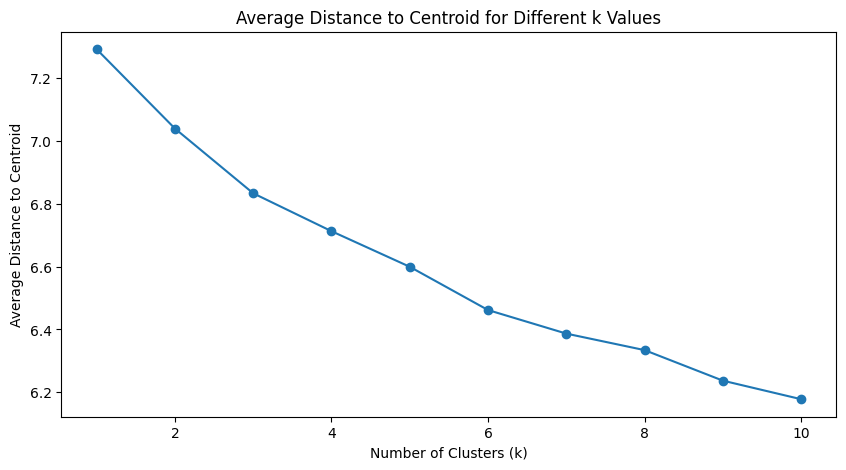

Best k: 10


In [15]:
X_train, X_val = feature[:4000], feature[4000:]
y_train, y_val = label[:4000], label[4000:]

k_range = range(1, 11)  # Checking k from 1 to 10
best_k = find_best_k(X_train, X_val, k_range)
print(f"Best k: {best_k}")


In [16]:
# # Use Silhouette Score to find best K
# from sklearn.metrics import silhouette_score
# def find_best_k_silhouette(X_train, k_range):
#     np.random.seed(42)
#     silhouette_scores = []
    
#     for k in k_range:
#         # Run k-means on training data
#         clusters, _, _ = kmeans(X_train, k=k)  # Unpack all three returned values, but only use clusters
        
#         # Compute silhouette score for the current k
#         score = silhouette_score(X_train, clusters)
#         silhouette_scores.append(score)
    
#     # Find the value of k that results in the highest silhouette score
#     best_k = k_range[np.argmax(silhouette_scores)]
    
#     # Plot the silhouette scores to visualize
#     plt.figure(figsize=(10, 5))
#     plt.plot(k_range, silhouette_scores, 'o-')
#     plt.xlabel('Number of Clusters (k)')
#     plt.ylabel('Silhouette Score')
#     plt.title('Silhouette Score for Different k Values')
#     plt.show()
    
#     return best_k


In [17]:
# k_range = range(2, 11)  # Starting from 2 because silhouette score requires at least 2 clusters
# best_k_silhouette = find_best_k_silhouette(X_pca, k_range)
# print(f"Best k using silhouette score: {best_k_silhouette}")

In [18]:
class KernelKMeans:
    def __init__(self, n_clusters=2, max_iter=1000, tol=1e-3, random_seed=42, sigma=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_seed = random_seed
        self.sigma = sigma
        np.random.seed(self.random_seed)

    def _rbf_kernel(self, X):
        sq_norms = np.sum(X**2, axis=1) # $||x_i-x_j||^2_2$
        sq_dists = -2 * np.dot(X, X.T) + sq_norms[:, np.newaxis] + sq_norms[np.newaxis, :] # $\sum_{j=1}^N||x_i-x_j||^2_2$
        if self.sigma is None:
            sigma_sq = np.mean(sq_dists) # $2\sigma^2$
        else:
            sigma_sq = self.sigma ** 2
        return np.exp(-sq_dists / (2 * sigma_sq))

    def fit(self, X, n_init=10):
        X = np.array(X)
        n_samples = X.shape[0]

        best_labels = None
        best_centers = None
        lowest_cost = np.inf

        for _ in range(n_init):
            # Compute the RBF kernel matrix
            K = self._rbf_kernel(X)

            # Initialize cluster assignments randomly
            labels = np.random.choice(self.n_clusters, size=n_samples)

            # Store the distances of each data point to each cluster center
            distance_to_clusters = np.zeros((self.n_clusters, n_samples))

            for iter in range(self.max_iter):
                """
                1. ensuring that the algorithm 
                doesn't run indefinitely if it doesn't converge
                2. repeat the update and assignment steps
                """
                # Update step
                for j in range(self.n_clusters):
                    mask_j = labels == j
                    K_j = K[:, mask_j]
                    denom = np.sum(mask_j)

                    if denom != 0:
                        # Distance based on the kernel values
                        dists_to_cluster = K.diagonal() - 2 * np.sum(K_j, axis=1) / denom + np.sum(K_j @ K_j.T) / (denom ** 2)
                        distance_to_clusters[j] = dists_to_cluster
                    else:
                        distance_to_clusters[j] = np.inf

                # Assignment step
                new_labels = np.argmin(distance_to_clusters, axis=0)

                # Check for convergence
                if np.sum(new_labels != labels) < self.tol:
                    break

                labels = new_labels

            # Compute the cost of the current solution
            cost = np.sum([distance_to_clusters[labels[i], i] for i in range(n_samples)])
            if cost < lowest_cost:
                best_labels = labels.copy()
                best_centers = distance_to_clusters.copy()
                lowest_cost = cost

        self.labels_ = best_labels
        self.cluster_centers_ = best_centers
        return self

    def predict(self, X):
        X = np.array(X)
        n_samples = X.shape[0]
        K = self._rbf_kernel(X)  # Kernel matrix between new data and training data

        dists = np.zeros((n_samples, self.n_clusters))
        for j in range(self.n_clusters):
            mask_j = self.labels_ == j
            K_j = K[:, mask_j]
            denom = np.sum(mask_j)

            if denom != 0:
                # Distance based on the kernel values
                dists_to_cluster = K.diagonal() - 2 * np.sum(K_j, axis=1) / denom + np.sum(K_j @ K_j.T) / (denom ** 2)
                dists[:, j] = dists_to_cluster
            else:
                dists[:, j] = np.inf

        return np.argmin(dists, axis=1)


In [19]:
X_rbf, y_rbf = feature.iloc[:500], label[:500]

In [20]:
# Find the best sigma
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

def evaluate_clustering(X, labels, true_labels):
    sil_score = silhouette_score(X, labels)
    ari = adjusted_rand_score(true_labels, labels)
    nmi = normalized_mutual_info_score(true_labels, labels)
    return sil_score, ari, nmi

def find_best_sigma(X, true_labels, sigmas, n_clusters=5, n_init=10):
    best_sigma = None
    best_avg_score = -np.inf  # Start with negative infinity to ensure we update this value
    best_num_clusters = 0
    
    for sigma in sigmas:
        sigma = round(sigma, 1)
        RBF_kmeans = KernelKMeans(n_clusters=n_clusters, sigma=sigma)
        RBF_kmeans.fit(X, n_init=n_init)
        predicted_labels = RBF_kmeans.predict(X)
        
        num_clusters = len(np.unique(predicted_labels))
        
        # Check if there's more than one unique label
        if num_clusters < 2:
            print(f"Sigma: {sigma} resulted in less than 2 clusters. Skipping...")
            continue
        
        sil_score, ari, nmi = evaluate_clustering(X, predicted_labels, true_labels)
        avg_score = np.mean([sil_score, ari, nmi])
        
        print(f"Sigma: {sigma}, Clusters: {num_clusters}, Silhouette Score: {sil_score}, ARI: {ari}, NMI: {nmi}")
        
        if avg_score > best_avg_score:
            best_avg_score = avg_score
            best_sigma = sigma
            best_num_clusters = num_clusters
            
    return best_sigma, best_num_clusters

# Define a range of sigma values to try
sigmas_to_try = np.linspace(0.1, 5, 50)

best_sigma, best_num_clusters = find_best_sigma(X_rbf, y_rbf, sigmas_to_try)
print(f"Best Sigma: {best_sigma} with {best_num_clusters} clusters.")


Sigma: 0.1, Clusters: 5, Silhouette Score: -0.011521420782715775, ARI: -0.0021562280761520864, NMI: 0.0149603186545172
Sigma: 0.2, Clusters: 5, Silhouette Score: -0.014091637656313943, ARI: -0.00031822822942835407, NMI: 0.017767054378870304
Sigma: 0.3, Clusters: 5, Silhouette Score: -0.013049717873363221, ARI: 0.0010228592735664482, NMI: 0.021090407169245307
Sigma: 0.4, Clusters: 5, Silhouette Score: -0.013049717873363221, ARI: 0.0010228592735664482, NMI: 0.021090407169245307
Sigma: 0.5, Clusters: 5, Silhouette Score: -0.013049717873363221, ARI: 0.0010228592735664482, NMI: 0.021090407169245307
Sigma: 0.6, Clusters: 5, Silhouette Score: -0.013049717873363221, ARI: 0.0010228592735664482, NMI: 0.021090407169245307
Sigma: 0.7, Clusters: 5, Silhouette Score: -0.013049717873363221, ARI: 0.0010228592735664482, NMI: 0.021090407169245307
Sigma: 0.8, Clusters: 5, Silhouette Score: -0.013049717873363221, ARI: 0.0010228592735664482, NMI: 0.021090407169245307
Sigma: 0.9, Clusters: 5, Silhouette Sco

In [21]:
# Apply KernelKMeans with the Best Sigma
RBF_kmeans = KernelKMeans(n_clusters=5, sigma=best_sigma)
RBF_kmeans.fit(X_rbf)
predicted_labels = RBF_kmeans.predict(X_rbf)

# Compute Additional Metrics
ari = adjusted_rand_score(y_rbf, predicted_labels)
nmi = normalized_mutual_info_score(y_rbf, predicted_labels)
print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")


Adjusted Rand Index: 0.004849548833857986
Normalized Mutual Information: 0.01603304046390908


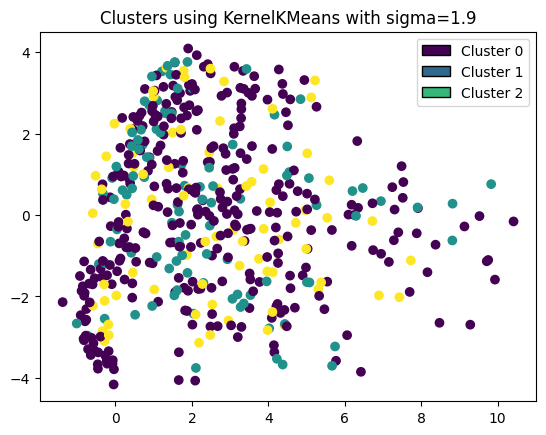

In [22]:
# Visualize the Clustering
from matplotlib.patches import Patch

X_rbf_pca = apply_pca(feature.iloc[:500],n_components=5)

# Visualize the Clusters (assuming X_rbf is 2D)
plt.scatter(X_rbf_pca[:, 0], X_rbf_pca[:, 1], c=predicted_labels, cmap='viridis')
plt.title(f"Clusters using KernelKMeans with sigma={best_sigma}")

# Create legend handles
legend_labels = [Patch(facecolor=plt.cm.viridis(i/best_num_clusters), edgecolor='k', label=f'Cluster {i}') for i in range(best_num_clusters)]
plt.legend(handles=legend_labels, loc='upper right')

plt.show()